In [ ]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func
from update import *
import os
import time as tm

# 初始化
num_vehicle = 20
num_order = 5
num_city = 5
TIME = 1440
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
# 获取图的邻接信息
adj_data = G.G.adjacency()
order_canceled = 0
# 将邻接信息保存为CSV文件
with open('adjacency.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'Adjacent Nodes'])  # CSV表头
    for node, neighbors in adj_data:
        writer.writerow([node, list(neighbors.keys())])  # 每一行包含节点和它的邻居

name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}
objval = 0.114514
invalid_time = 0
# 记录所有时间点车辆信息
all_vehicle_records = []
# 开始计时
start_time = tm.time()

for time in range(TIME):
    group = [[], []]
    
    # 记录每个时刻的车辆信息
    vehicle_records = []
    # 生成订单
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        orders_unmatched[order.id] = order
        Total_order[order.id] = order

    orders_virtual = orders_unmatched
    if time == 0:
        city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)
    else:
        city_node = city_update_without_drl(city_node , Vehicles,orders_unmatched)
    for vehicle in Vehicles.values():
        # 将车辆信息存入字典
        vehicle_records.append({
            "id": vehicle.id,
            "time": vehicle.time,
            "into_city": vehicle.into_city,
            "intercity": vehicle.intercity,
            "passenger": vehicle.get_capacity(),
            "decision": vehicle.decision,
            "battery": vehicle.battery,
            "whether_city":vehicle.whether_city,
            "matched_order": vehicle.orders,
            "num_matched": len(vehicle.get_orders()),
            "orders_unmatched" :len(orders_unmatched),
            "object_value": objval
        })

        # 通过条件分组
        if vehicle.whether_city:
            group[0].append(vehicle.id)
        else:
            group[1].append(vehicle.id)

    # 将当前时刻的车辆记录添加到所有记录中
    all_vehicle_records.append(vehicle_records)

    if len(group[0]) != 0:
        temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
        temp_Lower_Layer.get_decision()
        temp_Lower_Layer.constrain_1()
        temp_Lower_Layer.constrain_2()
        temp_Lower_Layer.constrain_3()
        temp_Lower_Layer.constrain_4()
        temp_Lower_Layer.constrain_5()
        temp_Lower_Layer.model.setParam('OutputFlag', 0)
        total_penalty = cancel_penalty * order_canceled
        temp_Lower_Layer.set_objective(matrix, total_penalty)
        """
        temp_Lower_Layer.model.setParam('Heuristics', 0.8)  # 提高启发式强度，范围为 [0, 1]
        temp_Lower_Layer.model.setParam('MIPFocus', 1)  # 更关注寻找可行解
        temp_Lower_Layer.model.setParam('PumpPasses', 10)  # 增强 Feasibility Pump
        temp_Lower_Layer.model.setParam('RINS', 5)  # 启用 RINS 方法
        """
       
        temp_Lower_Layer.model.optimize()

        #temp_Lower_Layer.model.optimize()

        if temp_Lower_Layer.model.status == GRB.OPTIMAL:
            save_results(temp_Lower_Layer,time)
            print("Objective value:", temp_Lower_Layer.model.objVal)
            objval = temp_Lower_Layer.model.objVal
        else:
            temp_Lower_Layer.model.computeIIS()
            temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
            print(f"{time}次，No optimal solution found.")
            self_update(Vehicles, G)
            objval = 0.114514
        
        _, var_order = temp_Lower_Layer.get_decision()
        update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
        vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
    
    else:
        self_update(Vehicles, G)
        print(f"{time}次，{len(group[1])}辆车不在城市")
        # vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
        objval = 0.114514
        invalid_time += 1
    print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时")
# 将记录保存为 CSV 文件
csv_file = "vehicle_records.csv"
with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
    # 写入CSV文件的列名
    fieldnames = ["id", "time", "into_city", "intercity", "passenger", "decision"
                ,"battery", "whether_city","matched_order","num_matched"
                ,"orders_unmatched","object_value"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    
    # 遍历所有时刻的车辆记录
    for vehicle_records in all_vehicle_records:
        writer.writerows(vehicle_records)
end_time = tm.time()
execution_time = end_time - start_time
print(f"执行时间: {execution_time} 秒")
print(f"Vehicle information saved to {csv_file},{invalid_time}")

In [ ]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func
from update import *
import os
import time as tm

# 初始化
num_vehicle = 20
num_order = 5
num_city = 5
TIME = 1440
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}
objval = 0
invalid_time = 0
# 记录所有时间点车辆信息
all_vehicle_records = []
# 开始计时
start_time = tm.time()

for time in range(TIME):
    group = [[], []]
    
    # 记录每个时刻的车辆信息
    vehicle_records = []
    # 生成订单
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        orders_unmatched[order.id] = order
        Total_order[order.id] = order

    orders_virtual = orders_unmatched
    if time == 0:
        city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)
    else:
        city_node = city_update_without_drl(city_node , Vehicles,orders_unmatched)
    for vehicle in Vehicles.values():
        # 将车辆信息存入字典
        vehicle_records.append({
            "id": vehicle.id,
            "time": vehicle.time,
            "into_city": vehicle.into_city,
            "intercity": vehicle.intercity,
            "passenger": vehicle.get_capacity(),
            "decision": vehicle.decision,
            "battery": vehicle.battery,
            "whether_city":vehicle.whether_city,
            "matched_order": vehicle.orders,
            "num_matched": len(vehicle.get_orders()),
            "orders_unmatched" :len(orders_unmatched),
            "object_value": objval
        })

        # 通过条件分组
        if vehicle.whether_city:
            group[0].append(vehicle.id)
        else:
            group[1].append(vehicle.id)

    # 将当前时刻的车辆记录添加到所有记录中
    all_vehicle_records.append(vehicle_records)

    if len(group[0]) != 0:
        temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
        temp_Lower_Layer.get_decision()
        temp_Lower_Layer.constrain_1()
        temp_Lower_Layer.constrain_2()
        temp_Lower_Layer.constrain_3()
        temp_Lower_Layer.constrain_4()
        temp_Lower_Layer.constrain_5()
        temp_Lower_Layer.model.setParam('OutputFlag', 0)
        total_penalty = cancel_penalty * order_canceled
        temp_Lower_Layer.set_objective(matrix)
        """
        temp_Lower_Layer.model.setParam('Heuristics', 0.8)  # 提高启发式强度，范围为 [0, 1]
        temp_Lower_Layer.model.setParam('MIPFocus', 1)  # 更关注寻找可行解
        temp_Lower_Layer.model.setParam('PumpPasses', 10)  # 增强 Feasibility Pump
        temp_Lower_Layer.model.setParam('RINS', 5)  # 启用 RINS 方法
        """

        temp_Lower_Layer.model.optimize()

        if temp_Lower_Layer.model.status == GRB.OPTIMAL:
            save_results(temp_Lower_Layer,time)
            print("Objective value:", temp_Lower_Layer.model.objVal)
            objval = temp_Lower_Layer.model.objVal 
        else:
            temp_Lower_Layer.model.computeIIS()
            temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
            print(f"{time}次，No optimal solution found.")
            self_update(Vehicles, G)
            objval = basic_cost(Vehicles, orders_unmatched)
            
        
        _, var_order = temp_Lower_Layer.get_decision()
        update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
        vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
        
    else:
        self_update(Vehicles, G)
        print(f"{time}次，{len(group[1])}辆车不在城市")
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
        objval = basic_cost(Vehicles, orders_unmatched)
        # 利润（如果有）减去新增的取消订单
        
        invalid_time += 1
    objval = objval - update_order(orders_unmatched, time, speed) * cancel_penalty 
    print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时,总利润为{objval}")
    
end_time = tm.time()
execution_time = end_time - start_time
print(f"执行时间: {execution_time} 秒,{invalid_time}次未求解")


In [ ]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func
from update import *
import os
import time as tm
import copy

# 初始化
num_vehicle = 20
num_order = 3
num_city = 8
TIME = 1440
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化车辆
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
# 获取图的邻接信息
adj_data = G.G.adjacency()
order_canceled = 0
# 将邻接信息保存为CSV文件
with open('adjacency.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'Adjacent Nodes'])  # CSV表头
    for node, neighbors in adj_data:
        writer.writerow([node, list(neighbors.keys())])  # 每一行包含节点和它的邻居

name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}
objval = 0.114514
# 生成每一个期的订单，作为强化学习的状态，因此不再是每阶段随机的
for time in range(TIME):
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        Total_order[order.id] = order
# 深复制最初的订单
prim_order = copy.deepcopy(Total_order)
prim_vehicle = copy.deepcopy(Vehicles)

# 记录所有时间点车辆信息
all_vehicle_records = []

# 开始计时
start_time = tm.time()

for time in range(TIME):
    group = [[], []]
    
    # 记录每个时刻的车辆信息
    vehicle_records = []
    # 生成订单
    
    for order in Total_order.values():
        if order.start_time == time:
            orders_unmatched[order.id] = order
    
    # 这里插入强化学习，决定虚拟订单

    orders_virtual = orders_unmatched
    if time == 0:
        city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)

    for vehicle in Vehicles.values():
        # 将车辆信息存入字典
        vehicle_records.append({
            "id": vehicle.id,
            "time": vehicle.time,
            "into_city": vehicle.into_city,
            "intercity": vehicle.intercity,
            "passenger": vehicle.get_capacity(),
            "decision": vehicle.decision,
            "battery": vehicle.battery,
            "whether_city":vehicle.whether_city,
            "matched_order": vehicle.orders,
            "num_matched": len(vehicle.get_orders()),
            "orders_unmatched" :len(orders_unmatched),
            "object_value": objval
        })

        # 通过条件分组
        if vehicle.whether_city:
            group[0].append(vehicle.id)
        else:
            group[1].append(vehicle.id)

    # 将当前时刻的车辆记录添加到所有记录中
    all_vehicle_records.append(vehicle_records)

    if len(group[0]) != 0:
        temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
        temp_Lower_Layer.get_decision()
        temp_Lower_Layer.constrain_1()
        temp_Lower_Layer.constrain_2()
        temp_Lower_Layer.constrain_3()
        temp_Lower_Layer.constrain_4()
        temp_Lower_Layer.constrain_5()
        temp_Lower_Layer.model.setParam('OutputFlag', 0)
        total_penalty = cancel_penalty * order_canceled
        temp_Lower_Layer.set_objective(matrix, total_penalty)
        """
        temp_Lower_Layer.model.setParam('Heuristics', 0.8)  # 提高启发式强度，范围为 [0, 1]
        temp_Lower_Layer.model.setParam('MIPFocus', 1)  # 更关注寻找可行解
        temp_Lower_Layer.model.setParam('PumpPasses', 10)  # 增强 Feasibility Pump
        temp_Lower_Layer.model.setParam('RINS', 5)  # 启用 RINS 方法
        """
       
        temp_Lower_Layer.model.optimize()

        #temp_Lower_Layer.model.optimize()

        if temp_Lower_Layer.model.status == GRB.OPTIMAL:
            save_results(temp_Lower_Layer,time)
            print("Objective value:", temp_Lower_Layer.model.objVal)
            objval = temp_Lower_Layer.model.objVal
        else:
            temp_Lower_Layer.model.computeIIS()
            temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
            print(f"{time}次，No optimal solution found.")
            self_update(Vehicles, G)
            objval = 0.114514
        
        _, var_order = temp_Lower_Layer.get_decision()
        update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
        vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
    
    else:
        self_update(Vehicles, G)
        print(f"{time}次，没有车")
        # vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
        order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
        objval = 0.114514
       
    print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时")
# 将记录保存为 CSV 文件
csv_file = "vehicle_records.csv"
with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
    # 写入CSV文件的列名
    fieldnames = ["id", "time", "into_city", "intercity", "passenger", "decision"
                ,"battery", "whether_city","matched_order","num_matched"
                ,"orders_unmatched","object_value"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    
    # 遍历所有时刻的车辆记录
    for vehicle_records in all_vehicle_records:
        writer.writerows(vehicle_records)
end_time = tm.time()
execution_time = end_time - start_time
print(f"执行时间: {execution_time} 秒")
print(f"Vehicle information saved to {csv_file}")

In [ ]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func
from update import *
import os
import time as tm

def run_simulation(num_vehicle, num_order, num_city, graph_density):
    # 初始化
    TIME = 1440
    CAPACITY = 7
    cancel_penalty = 300
    battery_consume = 10
    battery_add = 300
    speed = 20

    row = [10, 1, 3, 10]
    matrix = np.tile(row, (num_vehicle, 1))

    Vehicles = vehicle_generator(num_vehicle, num_city)
    orders_unmatched = {}
    G = CityGraph(num_city, graph_density, (10, 30))

    adj_data = G.G.adjacency()
    order_canceled = 0
    Total_order = {}
    objval = 0.114514
    all_vehicle_records = []

    # 开始计时
    start_time = tm.time()

    for time in range(TIME):
        group = [[], []]
        vehicle_records = []
        
        # 生成订单
        Orders = order_generator(num_order, time, num_city-1, CAPACITY, G, speed)
        for order in Orders.values():
            orders_unmatched[order.id] = order
            Total_order[order.id] = order

        orders_virtual = orders_unmatched
        if time == 0:
            city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)

        for vehicle in Vehicles.values():
            vehicle_records.append({
                "id": vehicle.id,
                "time": vehicle.time,
                "into_city": vehicle.into_city,
                "intercity": vehicle.intercity,
                "passenger": vehicle.get_capacity(),
                "decision": vehicle.decision,
                "battery": vehicle.battery,
                "whether_city": vehicle.whether_city,
                "matched_order": vehicle.orders,
                "num_matched": len(vehicle.get_orders()),
                "orders_unmatched": len(orders_unmatched),
                "object_value": objval
            })

            if vehicle.whether_city:
                group[0].append(vehicle.id)
            else:
                group[1].append(vehicle.id)

        all_vehicle_records.append(vehicle_records)

        if len(group[0]) != 0:
            temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, "navie", group, time)
            temp_Lower_Layer.get_decision()
            temp_Lower_Layer.constrain_1()
            temp_Lower_Layer.constrain_2()
            temp_Lower_Layer.constrain_3()
            temp_Lower_Layer.constrain_4()
            temp_Lower_Layer.constrain_5()
            temp_Lower_Layer.model.setParam('OutputFlag', 0)
            total_penalty = cancel_penalty * order_canceled
            temp_Lower_Layer.set_objective(matrix, total_penalty)
            temp_Lower_Layer.model.optimize()

            if temp_Lower_Layer.model.status == GRB.OPTIMAL:
                objval = temp_Lower_Layer.model.objVal
            else:
                temp_Lower_Layer.model.computeIIS()
                temp_Lower_Layer.model.write('iis.ilp')
                objval = 0.114514

            update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
            vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
            order_canceled += update_order(orders_unmatched, time, speed)

        else:
            self_update(Vehicles, G)
            vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
            order_canceled += update_order(orders_unmatched, time, speed)
            objval = 0.114514

    end_time = tm.time()
    execution_time = end_time - start_time
    print(f"执行时间: {execution_time} 秒")
    
    return order_canceled, all_vehicle_records

experiment_results = []

# 定义不同的测试参数
# 使用 numpy.linspace 来创建每个参数的 10 个点
num_vehicles_list = np.linspace(5, 10, 5, dtype=int)  # 车辆数量范围 [10, 100]
num_orders_list = np.linspace(1, 20, 20, dtype=int)      # 订单数量范围 [5, 50]
num_cities_list = np.linspace(5, 10, 5, dtype=int)      # 城市数量范围 [5, 20]
graph_densities = [0.3, 0.4]                         # 保持图的稠密度固定为 0.2, 0.3, 0.4


# 进行实验并记录结果
for num_vehicle in num_vehicles_list:
    for num_order in num_orders_list:
        for num_city in num_cities_list:
            for graph_density in graph_densities:
                print(f"Running simulation with {num_vehicle} vehicles, {num_order} orders, {num_city} cities, graph density {graph_density}...")
                order_canceled, all_vehicle_records = run_simulation(num_vehicle, num_order, num_city, graph_density)
                experiment_results.append({
                    "num_vehicle": num_vehicle,
                    "num_order": num_order,
                    "num_city": num_city,
                    "graph_density": graph_density,
                    "order_canceled": order_canceled
                })

# 将结果保存为CSV文件
with open("experiment_results.csv", mode="w", newline="", encoding="utf-8") as file:
    fieldnames = ["num_vehicle", "num_order", "num_city", "graph_density", "order_canceled"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for result in experiment_results:
        writer.writerow(result)

print("Experiment results saved to experiment_results.csv")


INFO:numexpr.utils:NumExpr defaulting to 16 threads.


回归系数: [ -412.31074324  1270.23986466   188.50277027 -1964.46      ]
截距: -272.28117354196365
num_vehicle: -412.3107432432433
num_order: 1270.2398646616548
num_city: 188.50277027027013
graph_density: -1964.4600000000157


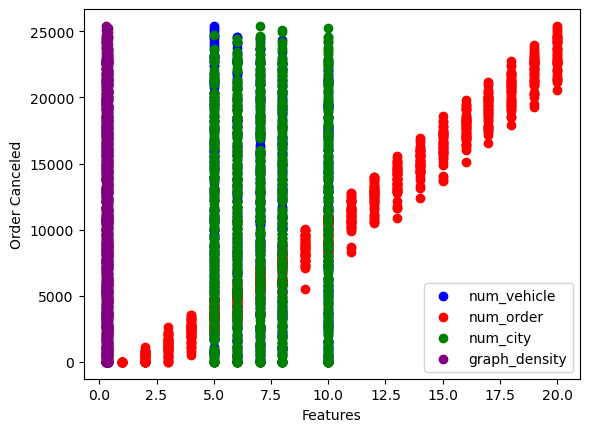

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 读取实验结果数据
data = pd.read_csv('experiment_results.csv')

# 准备自变量 (X) 和因变量 (y)
X = data[["num_vehicle", "num_order", "num_city", "graph_density"]]
y = data["order_canceled"]

# 创建并训练线性回归模型
model = LinearRegression()
model.fit(X, y)

# 输出回归系数和截距
print("回归系数:", model.coef_)
print("截距:", model.intercept_)

# 输出每个自变量对因变量的影响（回归系数）
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

# 可视化回归结果（可选）
# 这里我们只选择两个自变量来进行可视化
plt.scatter(data["num_vehicle"], y, color='blue', label='num_vehicle')
plt.scatter(data["num_order"], y, color='red', label='num_order')
plt.scatter(data["num_city"], y, color='green', label='num_city')
plt.scatter(data["graph_density"], y, color='purple', label='graph_density')
plt.xlabel("Features")
plt.ylabel("Order Canceled")
plt.legend()
plt.show()


第0次训练
未加强化学习利润为52581.0,0次未求解
模型参数已保存至 actor_critic_model0.pth
第1次训练
2
2
2
2
2
2
2


d:\mycodelife\workshop\DRL_CO\actor_critic.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_prob = action_dist.log_prob(torch.tensor(action).to(self.device))


2
2
2
执行时间: 0.2973034381866455 秒,0次未求解，当前强化学习值为-1529919.0,利润为52581.0
模型参数已保存至 actor_critic_model1.pth
第2次训练
模型参数已从 actor_critic_model1.pth 加载
2
2
2
2
2
2
2
2
2
2
执行时间: 0.5481243133544922 秒,0次未求解，当前强化学习值为-1529919.0,利润为52581.0
模型参数已保存至 actor_critic_model2.pth
第3次训练
模型参数已从 actor_critic_model2.pth 加载
2
2
2
2
2
2
2
2
2
2
执行时间: 0.8404731750488281 秒,0次未求解，当前强化学习值为-1529919.0,利润为52581.0
模型参数已保存至 actor_critic_model3.pth
第4次训练
模型参数已从 actor_critic_model3.pth 加载
2
2
2
2
2
2
2
2
2
2
执行时间: 1.0953421592712402 秒,0次未求解，当前强化学习值为-1529919.0,利润为52581.0
模型参数已保存至 actor_critic_model4.pth


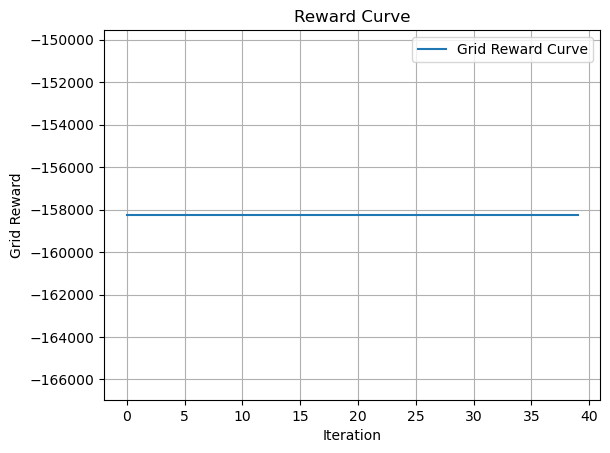

{}


In [3]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import importlib
import tool_func
from update import *
import os
import time as tm
import copy
from my_env import *
import torch
from actor_critic import *

"""这里是非强化学习部分"""
# 初始化
num_vehicle = 10
num_order = 2
num_city = 3
TIME = 10  # 
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20 # 之前是20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}

# 设置s_0
for time in range(TIME):
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        Total_order[order.id] = order

# 深复制最初的订单与车辆
prim_order = copy.deepcopy(Total_order)
prim_vehicle = copy.deepcopy(Vehicles)
"""这里是强化学习部分"""
# 超参数
STATE_DIM_VEHICLE = 11   # 车辆状态的特征维度
STATE_DIM_ORDER = 12     # 订单状态的特征维度
HIDDEN_DIM = 128         # 隐藏层维度
ACTION_DIM = num_city          # 动作空间维度
ACTOR_LR = 1e-2          # Actor 学习率
CRITIC_LR = 1e-2         # Critic 学习率
GAMMA = 0.99             # 折扣因子
NUM_EPISODES = 5      # 总训练轮数
STATE_DIM = (num_order * TIME+ num_vehicle)*HIDDEN_DIM       
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = ActorCritic(
    vehicle_dim=STATE_DIM_VEHICLE,
    order_dim=STATE_DIM_ORDER,
    state_dim=STATE_DIM,
    hidden_dim=HIDDEN_DIM,
    action_dim= num_order *TIME * num_city,
    actor_lr=ACTOR_LR,
    critic_lr=CRITIC_LR,
    gamma=GAMMA,
    device=DEVICE,
    num_order= num_order*TIME,
    num_city=num_city
)
grid_rewards = []
# 开始计时
start_time = tm.time()

episode_reward = 0
ACTIONS = []
base_revenue = []
first_revnue = []
base_vehicle = []
base_vehicle_class = []
base_order_class = []
base_city_node = []
for episode in range(NUM_EPISODES):
    print(f"第{episode}次训练")
    Total_order = copy.deepcopy(prim_order)
    Vehicles = copy.deepcopy(prim_vehicle)
    objval = 0
    total_objval = 0
    reward = 0
    episode_reward = 0
    invalid_time =  0
    orders_unmatched = {} # 忘记加这个了
    orders_virtual = {}
    
    if episode > 1:
        agent.load_model(load_path)
        env.time = 0

    for time in range(TIME):
    
        group = [[], []]

        # 按时间给出订单
        for order in Total_order.values():
            if order.start_time == time:
                orders_unmatched[order.id] = order
            # 加上这个代码后会导致性能降低
            """
            if order.matched is False:
                order.virtual_departure = order.departure 
            """
        if time != 0 and episode != 0:
            next_vehicle_states = vectorization_vehicle(Vehicles)
            next_order_states = vectorization_order(Total_order)
            # 这里防止梯度爆炸缩小了reward
            agent.update(vehicle_states, order_states, grid_reward, next_vehicle_states, next_order_states, True ,action)
            env.time = time
        if time == 0 :
            orders_virtual = orders_unmatched
           
            city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)
            if episode == 1 :
                env = DispatchEnv(
                    G=G,
                    vehicles=Vehicles,
                    orders=Total_order,
                    cities=city_node,
                    capacity=CAPACITY
                )
            elif episode > 1:
                env.cities = city_node
           
            
        else:
            if episode == 0:
                city_update_without_drl(city_node , Vehicles, orders_unmatched ,time)
            else:
                city_update_without_drl(env.cities , Vehicles, orders_unmatched, time)
            
        if episode != 0:
            
            vehicle_states = vectorization_vehicle(Vehicles)
            order_states = vectorization_order(Total_order)
            action = agent.take_action(vehicle_states, order_states)
            ACTIONS.append(action)            
            reward = env.step(action)
            change_time = 0
            for env_order in env.orders.values():
                for order_unmatched in orders_unmatched.values():
                    if env_order.id == order_unmatched.id:
                        order_unmatched.virtual_departure = env_order.virtual_departure
                        change_time += 1
            print(change_time)
            city_update_base_drl(env.cities, orders_unmatched ,time)

        for vehicle in Vehicles.values():
            if vehicle.whether_city:
                group[0].append(vehicle.id)
            else:
                group[1].append(vehicle.id)

        if len(group[0]) != 0:
            if episode == 0:
                temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
            else:
                temp_Lower_Layer = Lower_Layer(G, env.cities, Vehicles, orders_unmatched, name, group, time)
            temp_Lower_Layer.get_decision()
            temp_Lower_Layer.constrain_1()
            temp_Lower_Layer.constrain_2()
            temp_Lower_Layer.constrain_3()
            temp_Lower_Layer.constrain_4()
            temp_Lower_Layer.constrain_5()
            temp_Lower_Layer.model.setParam('OutputFlag', 0)
            total_penalty = cancel_penalty * order_canceled
            temp_Lower_Layer.set_objective(matrix)
        
            temp_Lower_Layer.model.optimize()

            if temp_Lower_Layer.model.status == GRB.OPTIMAL:
                save_results(temp_Lower_Layer,time)
                # print("Objective value:", temp_Lower_Layer.model.objVal)
                objval = temp_Lower_Layer.model.objVal 
            else:
                temp_Lower_Layer.model.computeIIS()
                temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
                # print(f"{time}次，No optimal solution found.")
                self_update(Vehicles, G)
                objval = basic_cost(Vehicles, orders_unmatched)
                
            
            _, var_order = temp_Lower_Layer.get_decision()
            update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
            vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
            order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            
        else:
            
            self_update(Vehicles, G)
            # print(f"{episode}轮，{time}次，{len(group[1])}辆车不在城市")
            order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            objval = basic_cost(Vehicles, orders_unmatched)
            # 利润（如果有）减去新增的取消订单
            
            invalid_time += 1
        objval = objval - update_order(orders_unmatched, time, speed) * cancel_penalty
        if episode != 0: 
            
            # 防止梯度爆炸
            grid_reward =  reward
            grid_rewards.append(grid_reward)
            # print(grid_reward)
            episode_reward += reward + objval
        total_objval += objval

        if episode == 0:
            base_revenue.append(objval)
            base_vehicle.append(copy.deepcopy(group[0]))
            # base_vehicle_class.append(copy.deepcopy(Vehicles))
            # base_order_class.append(copy.deepcopy(Total_order))
            
            base_city_node.append(copy.deepcopy(city_node))
            """
            if episode == 1:
                first_revnue.append(objval)
            """
        else:
            # if base_revenue[time] != objval:
            #    print("base_revenue",time, objval,base_revenue[time])
            # if first_revnue[time] != objval:
            #    print("first_revenue",time, first_revnue[time], objval)
            """ 
            if base_vehicle[time] != group[0]:
                print("vehicle is different", len(base_vehicle[time]), len(group[0]))
            if base_city_node[time] != env.cities:
                print(time, base_city_node[time],"\n", env.cities)
            """
            
        # print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时,总利润为{objval},强化学习利润为{reward}")
    end_time = tm.time()
    execution_time = end_time - start_time
    if episode != 0:
        print(f"执行时间: {execution_time} 秒,{invalid_time}次未求解，当前强化学习值为{episode_reward},利润为{total_objval}")
        # torch.save(agent.state_dict(), 'model_checkpoint.pth')
    else:
        print(f"未加强化学习利润为{total_objval},{invalid_time}次未求解")
    # grid_rewards.append(0)
    save_path = f"actor_critic_model{episode}.pth"
    load_path = f"actor_critic_model{episode}.pth"
    agent.save_model(save_path)
plt.plot(grid_rewards, label='Grid Reward Curve')
plt.xlabel('Iteration')
plt.ylabel('Grid Reward')
plt.title('Reward Curve')
plt.legend()
plt.grid(True)
plt.show()
print(find_duplicates_with_positions(ACTIONS))

In [4]:
duplicates = {}
for i in range(len(ACTIONS)):
    for j in range(i + 1, len(ACTIONS)):
        if torch.equal(ACTIONS[i], ACTIONS[j]):
            if i not in duplicates:
                duplicates[i] = []
            duplicates[i].append(j)

# 输出重复矩阵及其位置
print("重复的矩阵及其位置:")
for key, value in duplicates.items():
    print(f"矩阵 {key} 与位置 {value} 重复")

重复的矩阵及其位置:


In [5]:
duplicates = {}
for i in range(len(grid_rewards)):
    for j in range(i + 1, len(grid_rewards)):
        if grid_rewards[i] == grid_rewards[j]:
            if i not in duplicates:
                duplicates[i] = []
            duplicates[i].append(j)

# 输出重复矩阵及其位置
print("重复的矩阵及其位置:")
for key, value in duplicates.items():
    print(f"矩阵 {key} 与位置 {value} 重复")

重复的矩阵及其位置:
矩阵 0 与位置 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 1 与位置 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 2 与位置 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 3 与位置 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 4 与位置 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 5 与位置 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 重复
矩阵 6 与位置 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,

In [6]:
print(ACTIONS[0])

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])


In [7]:
print(ACTIONS[1])

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])


In [14]:
for i in range(7):
    if i<6:
        path_before = f"actor_critic_model{i}.pth"
        path_after = f"actor_critic_model{i+1}.pth"
        if compare_model(path_before, path_after):
            print(i,i+1)

参数 fc1.weight 在 critic 中发生了变化
参数 fc1.weight 在 critic 中发生了变化
参数 fc1.weight 在 critic 中发生了变化
参数 fc1.weight 在 critic 中发生了变化
参数 fc1.weight 在 critic 中发生了变化
参数 fc1.weight 在 critic 中发生了变化
